In [1]:
from github import Github
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import time
import math
import ast
import datetime
from scipy.stats import linregress

In [2]:
# this is to ignore a warning later in the code
pd.set_option('mode.chained_assignment', None)

In [3]:
# g = Github("...")

In [4]:
# repo_owner = 'numpy'
# repo_name = 'numpy'

In [5]:
# repo = g.get_repo(f"{repo_owner}/{repo_name}")
# page_size = 100 #shame on me this assumption is not right...

In [6]:
# num_prs = repo.get_pulls(state = 'all').totalCount
# num_requests = math.ceil(num_prs / page_size) #because page_size is wrong, this result is also wrong, but that's enough to analyze
# delay = 60

I commented this whole cell below since I did not want to waste another 4 hours of my life

In [7]:
# prs = repo.get_pulls(state = 'all')
# data = []
# for i in range(num_requests):
#     print(i)
#     # Retrieve the pull requests for the current page
#     current_page_prs = prs.get_page(i)

#     # Process the pull requests for the current page
#     for pr in current_page_prs:
#         data.append([
#             pr.id,
#             pr.number,
#             pr.title, 
#             pr.additions, 
#             pr.deletions,
#             pr.state,
#             pr.created_at, 
#             pr.closed_at,
#             pr.commits, 
#             len([l.name for l in pr.labels]),
#             [l.name for l in pr.labels],
#             pr.user.name, 
#             pr.user.id, 
#             pr.user.email, 
#             pr.user.type, 
#         ])
    
#     # Sleep for the calculated delay to avoid rate limiting
#     time.sleep(delay)
# df = pd.DataFrame(data, columns = ['id', 'number', 'title', 'additions', 'deletions', 'state', 'created', 'closed', 'commit-count', 'label-count', 'labels', 'contributor-name', 'contributor-id', 'contributor-email', 'contributor-type'])
# df.to_csv('numpy-pr.csv')

In [8]:
# After the first run, I got data stored in a csv file so I'm gonna use that for later runs
df = pd.read_csv('data/numpy-pr.csv', index_col = [0])

I have 3720 pull requests, ranging from 2020 November to 2023 May (now)

In [9]:
df.dtypes

id                    int64
number                int64
title                object
additions             int64
deletions             int64
state                object
created              object
closed               object
commit-count          int64
label-count           int64
labels               object
contributor-name     object
contributor-id        int64
contributor-email    object
contributor-type     object
dtype: object

In [10]:
# change 2 datetime columns to preferable type
df['created'] = pd.to_datetime(df['created'])
df['closed'] = pd.to_datetime(df['closed'])

In [11]:
# Clean out pull requests created before 2020 November
df = df.loc[df['created'] >= '2020-11-01 00:00:00']

In [12]:
# Currently the 'labels' column is not yet an array column, so I have to make it become an array column as intended
df['labels'] = df['labels'].apply(lambda x: ast.literal_eval(x))

In [13]:
# Fill in unknown name and email
df['contributor-name'].fillna('Unknown', inplace = True)
df['contributor-email'].fillna('Unknown', inplace = True)

In [14]:
# Remove pull requests without any changes (how!?)
df = df.loc[df['commit-count'] > 0]
df = df.loc[(df['additions'] > 0) | (df['deletions'] > 0)]

In [15]:
df.reset_index(drop = True, inplace = True)

In [16]:
df.dtypes

id                            int64
number                        int64
title                        object
additions                     int64
deletions                     int64
state                        object
created              datetime64[ns]
closed               datetime64[ns]
commit-count                  int64
label-count                   int64
labels                       object
contributor-name             object
contributor-id                int64
contributor-email            object
contributor-type             object
dtype: object

It's time to analyze the data

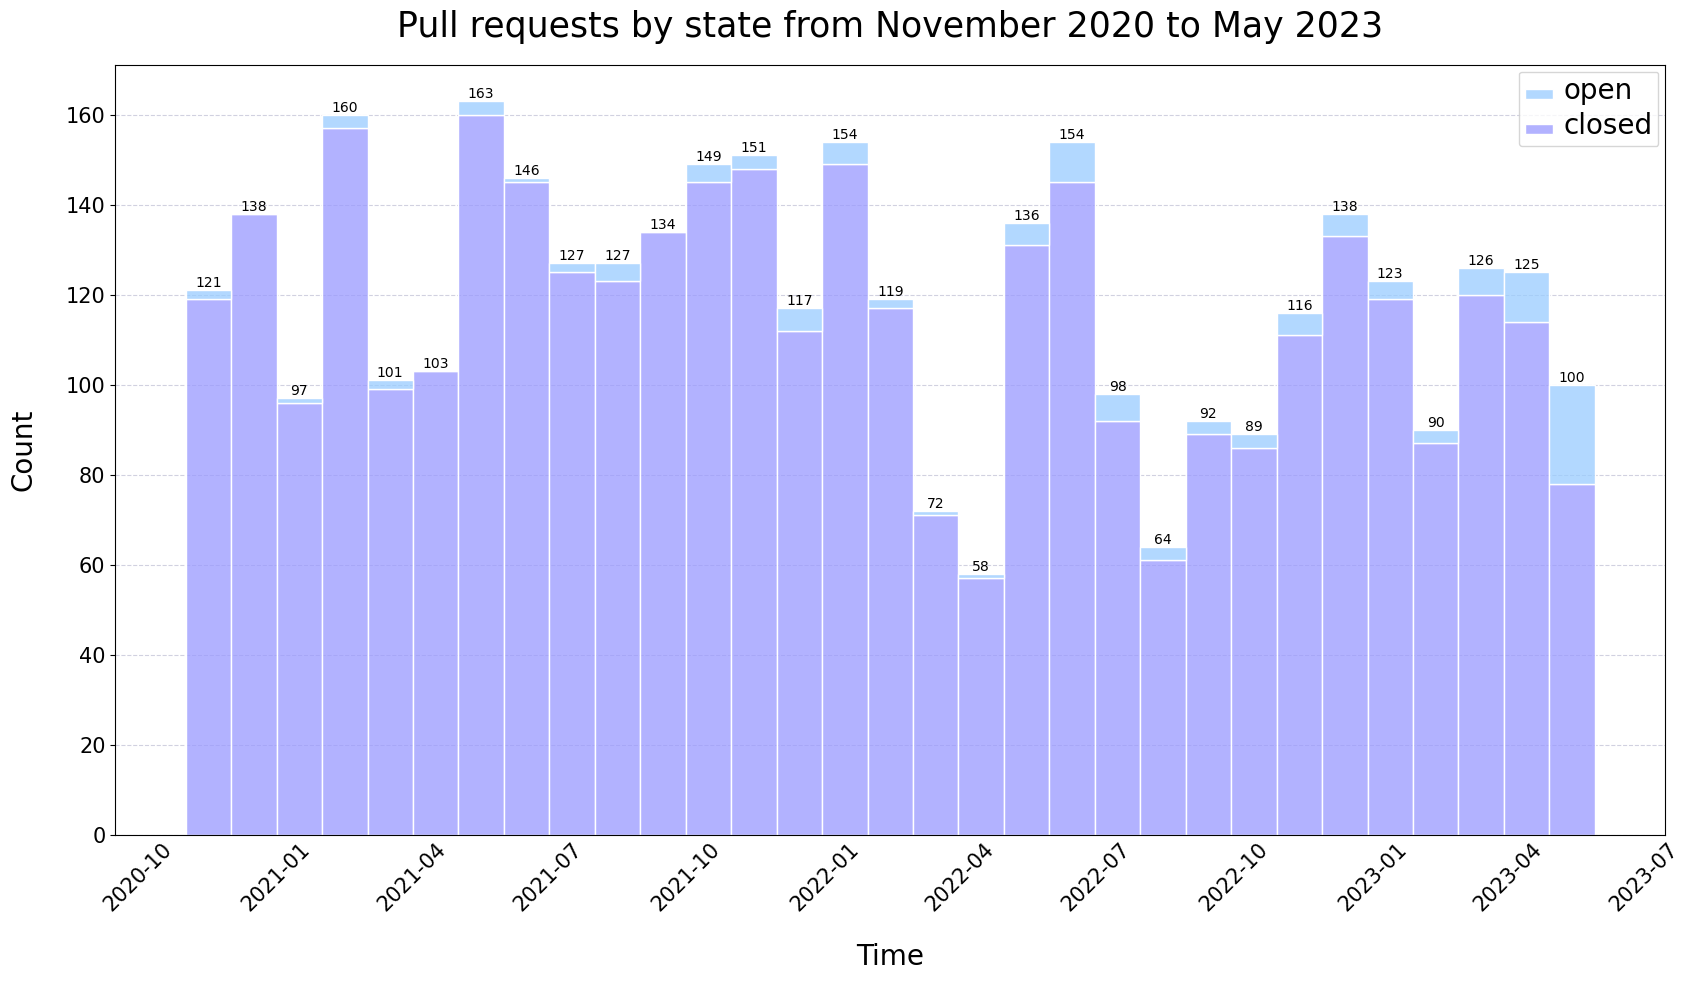

In [17]:
fig = plt.figure(figsize = (20, 10))
ax = sns.histplot(data = df, x = 'created', multiple = 'stack', hue = 'state', palette = ['#99ccff', '#9999ff'], hue_order = ['open', 'closed'], bins = 31, edgecolor = 'white')
plt.title('Pull requests by state from November 2020 to May 2023', fontsize = 25, pad = 20)
ax.bar_label(ax.containers[1])
ax.set_axisbelow(True)
ax.grid(axis = 'y', color = '#d1d1e0', linestyle = 'dashed')
plt.xlabel('Time', fontsize = 20, labelpad = 20)
plt.ylabel('Count', fontsize = 20, labelpad = 20)
plt.tick_params(axis = 'x', length = 0)
plt.xticks(fontsize = 15, rotation = 45)
plt.yticks(fontsize = 15)
ax.get_legend().set_title('')
plt.setp(ax.get_legend().get_texts(), fontsize = '20') 
plt.show()

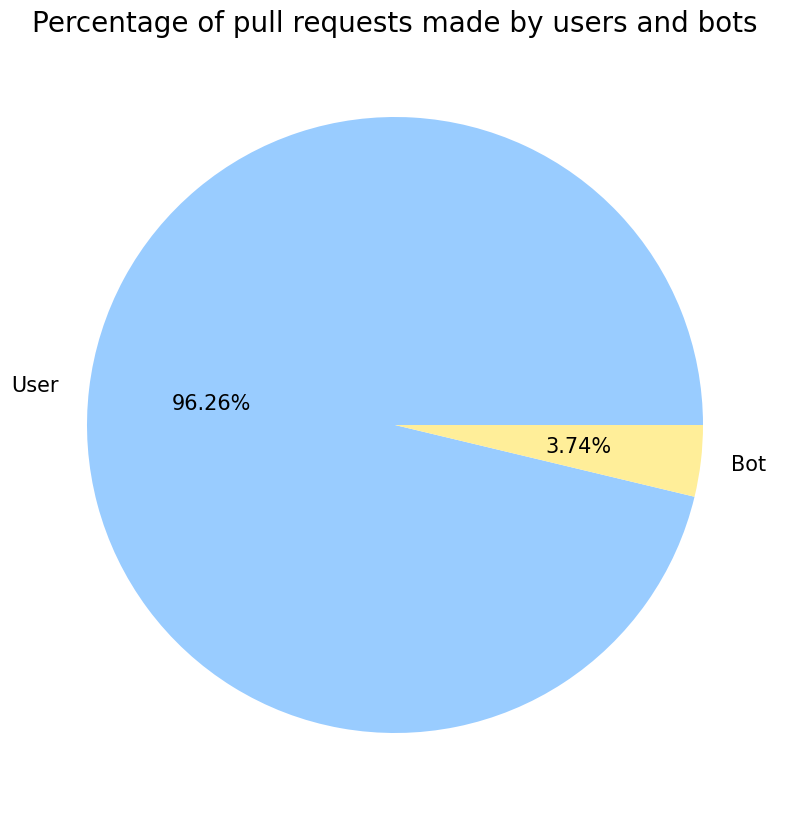

In [18]:
fig = plt.figure(figsize = (10, 10))
df['contributor-type'].value_counts().plot(kind = 'pie', fontsize = 15, autopct = '%1.2f%%', colors = ['#99ccff', '#ffee99'])
plt.title('Percentage of pull requests made by users and bots', fontsize = 20)
plt.ylabel('')
plt.show()

In [19]:
df.loc[df['contributor-type'] == 'Bot', 'labels'].explode('labels').value_counts().head(1)

03 - Maintenance    126
Name: labels, dtype: int64

In [20]:
print(round(df.loc[df['contributor-type'] == 'Bot', 'labels'].explode('labels').value_counts().head(1)[0] / df.loc[df['contributor-type'] == 'Bot'].shape[0] * 100 , 1), '\b%')

91.3%


We can easily see that Bots often work on 'Maintenance'

In [21]:
df['label-count'].value_counts()

1    1828
2    1136
3     387
0     292
4      39
5       5
6       1
Name: label-count, dtype: int64

In [22]:
df_exploded = df.explode('labels')
label_freq = df_exploded['labels'].value_counts()
top5_label = label_freq.head(5)
top5_label

03 - Maintenance      977
04 - Documentation    779
00 - Bug              739
01 - Enhancement      463
08 - Backport         451
Name: labels, dtype: int64

That's top 5 labels! Let's demonstrate its percentage using pie chart.

In [23]:
# add all non-label pull requests
non_label = pd.DataFrame(df[df['label-count'] == 0].shape[0], columns = [0], index = ['No tag'])
# set up remaining labels as 'other'
other_label = label_freq[5:].sum()
other_label = pd.DataFrame(other_label, columns = [0], index = ['Other'])
new_label_df = pd.concat([top5_label, non_label, other_label], axis = 0)
new_label_df.rename(columns = {0: 'count'}, inplace = True)
new_label_df

,count
03 - Maintenance,977
04 - Documentation,779
00 - Bug,739
01 - Enhancement,463
08 - Backport,451
No tag,292
Other,2039


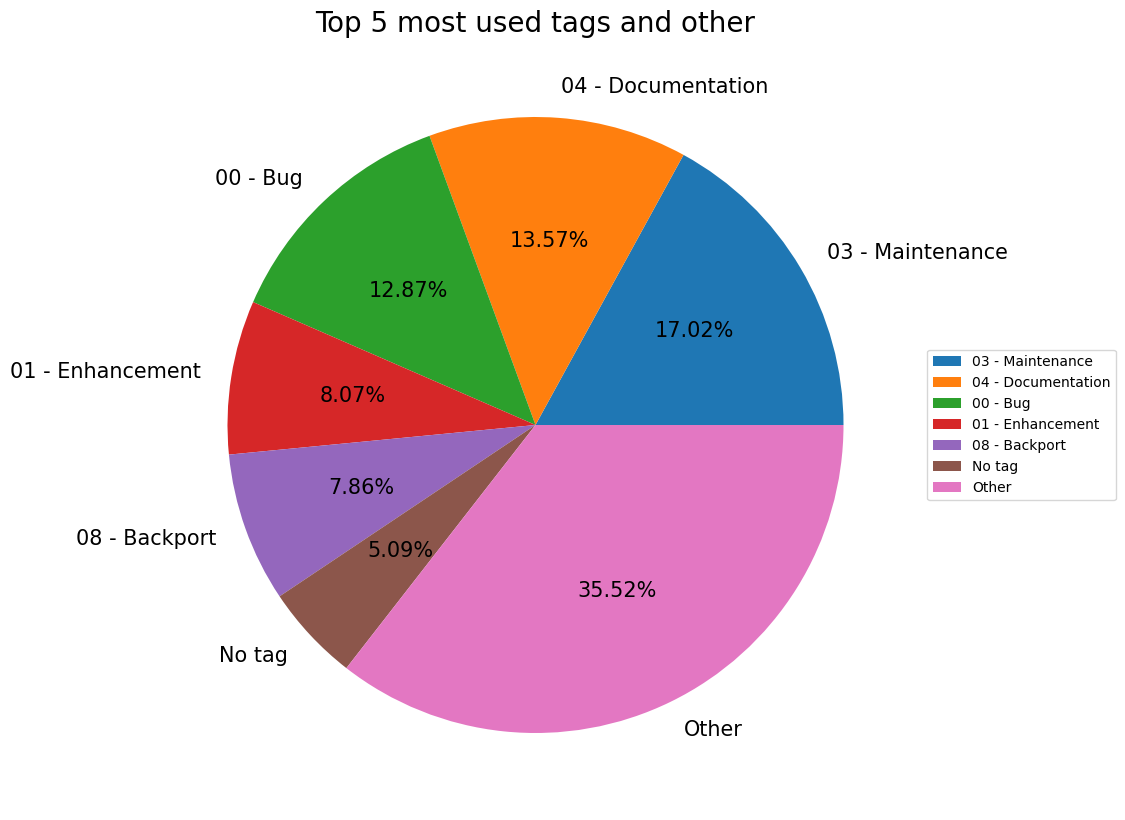

In [24]:
# Demonstration
new_label_df.plot(kind = 'pie', y = 'count', autopct = '%1.2f%%', figsize = (10, 10), fontsize = 15)
plt.title('Top 5 most used tags and other', fontsize = 20)
plt.ylabel('')
plt.legend(loc = 'center left', bbox_to_anchor = (1.0, 0.5))
plt.show()

I will find which user (or maybe bot) has the most pull requests and most commits.

In [25]:
top6_contributor = df[['contributor-name', 'contributor-id', 'contributor-email', 'contributor-type']].value_counts().head(6).reset_index()
top6_contributor.rename(columns = {0: 'count'}, inplace = True)
top6_contributor

,contributor-name,contributor-id,contributor-email,contributor-type,count
0,Charles Harris,77272,charlesr.harris@gmail.com,User,674
1,Sebastian Berg,61977,sebastian@sipsolutions.net,User,333
2,Bas van Beek,43369155,Unknown,User,244
3,Matti Picus,823911,mattigit@picus.org.il,User,151
4,Ralf Gommers,98330,ralf.gommers@gmail.com,User,91
5,Unknown,49699333,Unknown,Bot,87


I want to analyze how many changes were made in each pr

I will create a new dataframe for this because I need to clean some pull requests with too many changes.

In [26]:
df_change = df[(df['additions'] <= df['additions'].quantile(0.975)) & (df['deletions'] <= df['deletions'].quantile(0.975))]

Text(0, 0.5, 'Number of lines')

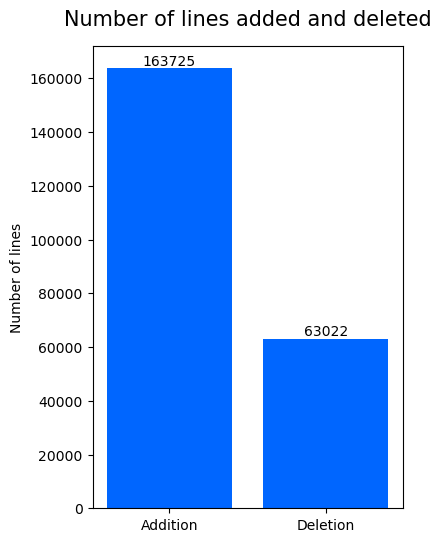

In [27]:
total_change = [df_change['additions'].sum(), df_change['deletions'].sum()]
fig, ax = plt.subplots(figsize = (4, 6))
barplot = plt.bar(x = ['Addition', 'Deletion'], height = total_change, color = '#0066ff')
ax.bar_label(barplot)
plt.title('Number of lines added and deleted', fontsize = 15, pad = 15)
plt.ylabel('Number of lines')

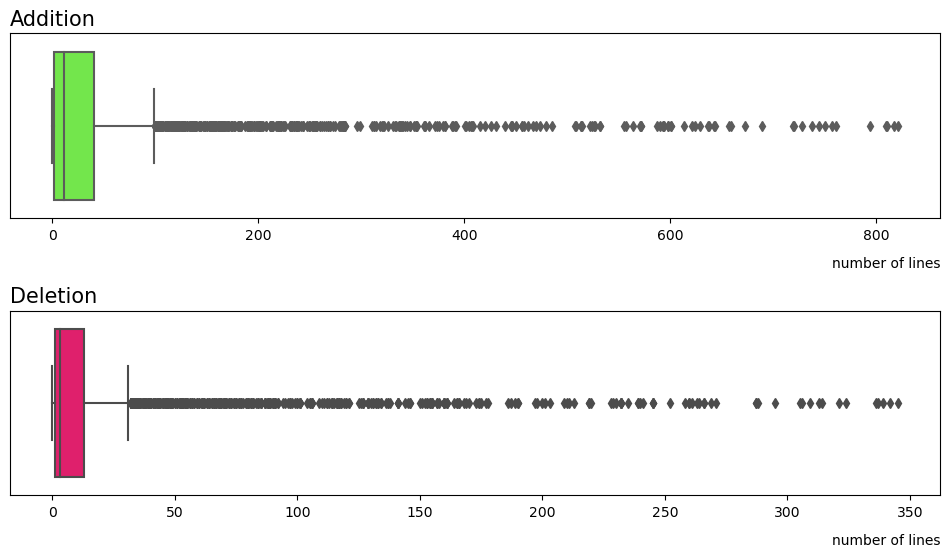

In [28]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize = (12, 6))
sns.boxplot(data = df_change, x = 'additions', ax = ax1, color = '#66ff33')
sns.boxplot(data = df_change, x = 'deletions', ax = ax2, color = '#ff0066')
ax1.set_title('Addition', loc = 'left', fontsize = 15)
ax2.set_title('Deletion', loc = 'left', fontsize = 15)
ax1.axes.yaxis.set_ticks([])
ax2.axes.yaxis.set_ticks([])
ax1.set_xlabel('number of lines', loc = 'right', labelpad = 10)
ax2.set_xlabel('number of lines', loc = 'right', labelpad = 10)
fig.subplots_adjust(hspace = 0.5)
plt.show()

In [29]:
# Create a new column name 'change-per-commit' to analyze relation between them
df_change.loc[:, 'change'] = df_change['additions'] + df_change['deletions']
df_change.loc[:, 'change-per-commit'] = df_change['change'] / df['commit-count']

In [30]:
print('average:\t', round(df_change['change-per-commit'].mean(), 1))
print('max:\t\t', round(df_change['change-per-commit'].max(), 1))
print('min:\t\t', round(df_change['change-per-commit'].min(), 1))

average:	 30.0
max:		 975.0
min:		 0.3


Now I want to work on closed pull requests. How long on average did a pr open?

In [31]:
# Of all the closed prs, how long did a prs being used?
df_closed = df.loc[df['state'] == 'closed']
df_closed.loc[:, 'duration'] = df_closed['closed'] - df_closed['created']
df_closed['duration']

0        0 days 00:56:27
6        0 days 01:01:41
8        0 days 03:11:14
9        0 days 00:34:52
10       0 days 07:12:40
              ...       
3683     0 days 12:08:36
3684     0 days 07:27:57
3685     2 days 08:59:07
3686     0 days 20:51:28
3687   249 days 03:47:33
Name: duration, Length: 3564, dtype: timedelta64[ns]

In [32]:
print('average:\t', datetime.timedelta(seconds = round(df_closed['duration'].mean().total_seconds())))
print('max:\t\t', df_closed['duration'].max())
print('min:\t\t', df_closed['duration'].min())

average:	 15 days, 17:12:40
max:		 866 days 05:00:18
min:		 0 days 00:00:06


In [33]:
# I want to divided them to several categories: 'Under a min', 'Under an hour', 'Under a day', 'Under a month', 'Under a year', 'More than a year'
# We assume that 'Under a day' here for instance is <= a day but > an hour
# To make that create a new column :D
# Working with timedelta type is pretty annoying so I change it to seconds

df_closed['duration-seconds'] = df_closed['duration'].dt.total_seconds()
df_closed.loc[df_closed['duration-seconds'] <= 60, 'duration-type'] = 'Under a min'
df_closed.loc[(df_closed['duration-seconds'] <= 3600) & (df_closed['duration-seconds'] > 60), 'duration-type'] = 'Under an hour'
df_closed.loc[(df_closed['duration-seconds'] <= 86400) & (df_closed['duration-seconds'] > 3600), 'duration-type'] = 'Under a day'
df_closed.loc[(df_closed['duration-seconds'] <= 2592000) & (df_closed['duration-seconds'] > 86400), 'duration-type'] = 'Under a month'
df_closed.loc[(df_closed['duration-seconds'] <= 31536000) & (df_closed['duration-seconds'] > 2592000), 'duration-type'] = 'Under a year'
df_closed.loc[df_closed['duration-seconds'] > 31536000, 'duration-type'] = 'More than a year'
df_closed['duration-type']

0       Under an hour
6         Under a day
8         Under a day
9       Under an hour
10        Under a day
            ...      
3683      Under a day
3684      Under a day
3685    Under a month
3686      Under a day
3687     Under a year
Name: duration-type, Length: 3564, dtype: object

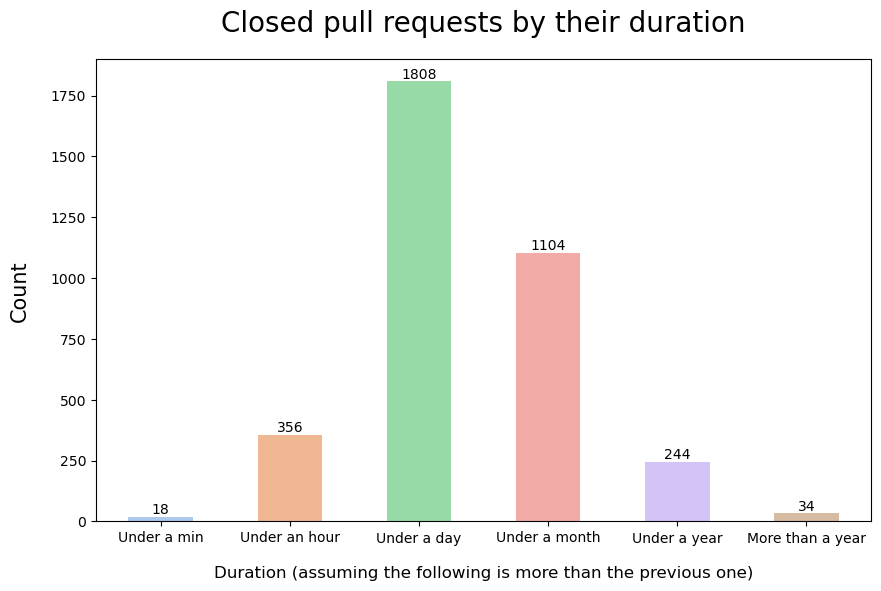

In [34]:
fig = plt.figure(figsize = (10, 6))
order = ['Under a min', 'Under an hour', 'Under a day', 'Under a month', 'Under a year', 'More than a year']
duration_count = df_closed['duration-type'].value_counts().loc[order]
ax = sns.barplot(x = duration_count.index, y = duration_count.values, order = order, palette = 'pastel', width = 0.5)
ax.bar_label(ax.containers[0])
plt.title('Closed pull requests by their duration', fontsize = 20, pad = 20)
plt.xlabel('Duration (assuming the following is more than the previous one)', fontsize = 12, labelpad = 15)
plt.ylabel('Count', fontsize = 15, labelpad = 15)
plt.show()

That's all I want to know about this repository's pull requests!

How about commit? I don't have the luxury of extracting everything since it takes too much time for my poor connection to handle, so I will just analyze commits in open pull requests.

In [35]:
# # The data is so huge that I don't wanna extract all commits. Maybe for just open prs it's managable, but do I even have enough time to do so...
# open_prs = repo.get_pulls(state = 'open')
# data = []
# for pr in open_prs:
#     commits = pr.get_commits()
#     # iterate through each commit and print its information
#     for commit in commits:
#         data.append([commit.sha, commit.commit.author.name, commit.commit.author.email, commit.commit.author.date, commit.commit.message, len(commit.files)])
# df = pd.DataFrame(data, columns = ['id', 'name', 'email', 'date', 'message', 'file-changed-count'])
# df.to_csv('numpy-commit.csv')

In [36]:
df_commit = pd.read_csv('data/numpy-commit.csv', parse_dates = ['date'], index_col = [0])

In [37]:
# Cleaning data
df_commit = df_commit.loc[~df_commit['message'].str.contains('merge|Merge|pull|branch')]
df_commit = df_commit.loc[df_commit['file-changed-count'] > 0]

In [38]:
df_commit.reset_index(drop = True, inplace = True)

In [39]:
# Avg, max, min of file changed
print('average:\t', round(df_commit['file-changed-count'].mean(), 2))
print('max:\t\t', df_commit['file-changed-count'].max())
print('min:\t\t', df_commit['file-changed-count'].min())
print('percentage of commit that only changed 1 file:', round(df_commit[df_commit['file-changed-count'] == 1].shape[0] / df_commit.shape[0] * 100, 2), '\b%')

average:	 1.88
max:		 64
min:		 1
percentage of commit that only changed 1 file: 70.3%


In [40]:
# Working with time
df_commit['year'] = df_commit['date'].dt.year
order = np.arange(2016, 2024, 1)
commit_by_year = df_commit['year'].value_counts().reindex(index = order, fill_value = 0)

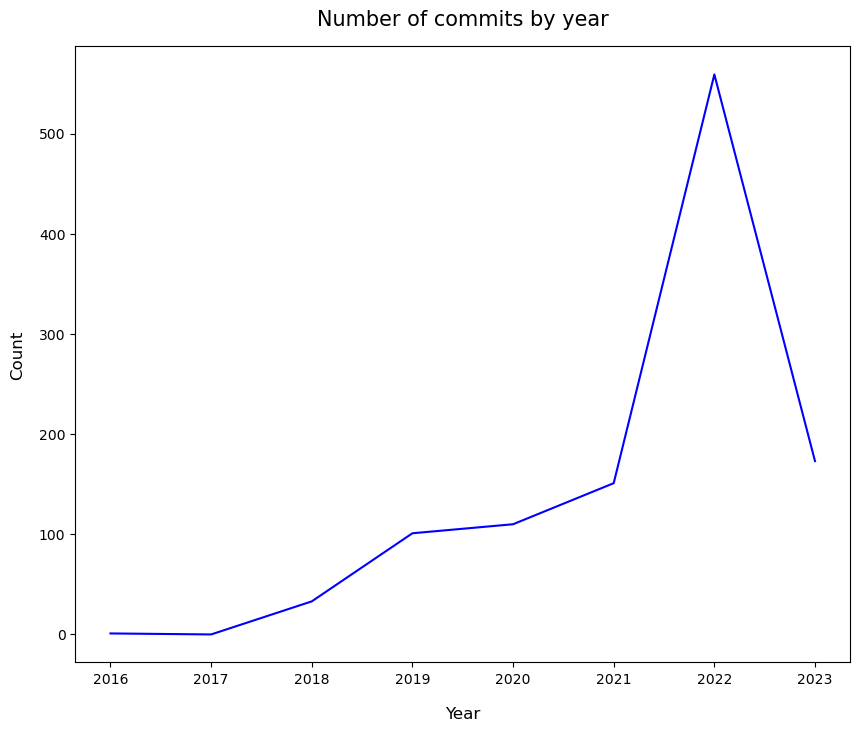

In [41]:
# Demonstration
fig = plt.figure(figsize = (10, 8))
sns.lineplot(data = commit_by_year, color = 'blue')
plt.title('Number of commits by year', fontsize = 15, pad = 15)
plt.xlabel('Year', fontsize = 12, labelpad = 15)
plt.ylabel('Count', fontsize = 12, labelpad = 10)
plt.show()

In [42]:
top5_contributor = df_commit[['name', 'email']].value_counts().head(5).reset_index()
top5_contributor.rename(columns = {0: 'count'}, inplace = True)
top5_contributor

,name,email,count
0,Namami Shanker,namami2011@gmail.com,235
1,Rohit Goswami,rog32@hi.is,45
2,Sebastian Berg,sebastianb@nvidia.com,36
3,Ganesh Kathiresan,ganesh3597@gmail.com,31
4,Ivan Gonzalez,scratchmex@gmail.com,25


That's all!